In [1]:
import numpy as np
import pandas as pd
import nag4py.e01 as e01
import nag4py.util as util
import nag4py.g13 as g13
import matplotlib.pyplot as plt
%matplotlib inline  

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 6 days

    After the trial mode has expired, if you want to use mkl thereafter,
    please purchase a license at http://continuum.io
    


# Read in Volkswagen Stock Price

In [2]:
data = pd.read_csv('volkswagen.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,07/12/2015,138.85,138.85,135.75,136.05,111000,136.05
1,04/12/2015,137.40,139.75,136.40,137.30,184700,137.30
2,03/12/2015,137.85,142.35,136.75,136.75,229400,136.75
3,02/12/2015,140.15,140.80,133.50,137.85,240200,137.85
4,01/12/2015,142.80,146.50,139.50,139.65,401800,139.65


# Set Date as Index

In [3]:
data.Date = pd.to_datetime(data.Date, dayfirst=True)

In [4]:
data = data.set_index(['Date']).sort_index(ascending=True)
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1995-03-24,17.1538,17.2050,17.0000,17.4095,0,13.7543
1995-03-27,17.6907,17.8952,17.5884,17.2050,0,13.5927
1995-03-28,17.5884,17.6038,17.2050,17.2050,0,13.5927
1995-03-30,17.1794,17.7930,17.1794,17.7418,0,14.0168
1995-03-31,18.0844,18.0997,17.7418,17.8697,0,14.1178


# Identify Missing Dates

In [5]:
known_dates = data.index.sort_values()
all_dates = pd.date_range(known_dates[0], known_dates[-1])
missing_dates = all_dates.difference(known_dates)

# Choose a Price

In [6]:
price_type = 'High'
known_prices = getattr(data, price_type).sort_index().values

# Interpolate the Missing Data using NAG's Monotonicity Preserving Routine

In [7]:
def mono_inter(x, y, missing_dates):
    """This function calcuates the missing prices from the known dates, known prices and missing dates. 
        x is the known dates
        y is the known prices
        md is the missing dates"""
    d = np.zeros(len(x))
    fail = util.noisy_fail()
    e01.nag_monotonic_interpolant(len(x), x, y, d, fail)
    missing_prices = np.zeros(len(missing_dates))
    fail = util.noisy_fail()
    e01.nag_monotonic_evaluate(len(x), x, y, d, len(missing_dates), missing_dates, missing_prices, fail)
    if fail.iflag != 0:
        print fail.message
    return missing_prices

In [8]:
missing_prices = mono_inter(known_dates.values.astype(float), known_prices, missing_dates.values.astype(float))

# Join the two Dataframes together

In [9]:
missing_data = pd.DataFrame(missing_prices, missing_dates, columns=[price_type])
known_data = pd.DataFrame(known_prices, known_dates, columns=[price_type])

In [10]:
all_data = pd.concat([missing_data, known_data]).sort_index()
all_data.head()

,High
1995-03-24,17.205000
1995-03-25,17.660015
1995-03-26,17.854296
1995-03-27,17.895200
1995-03-28,17.603800


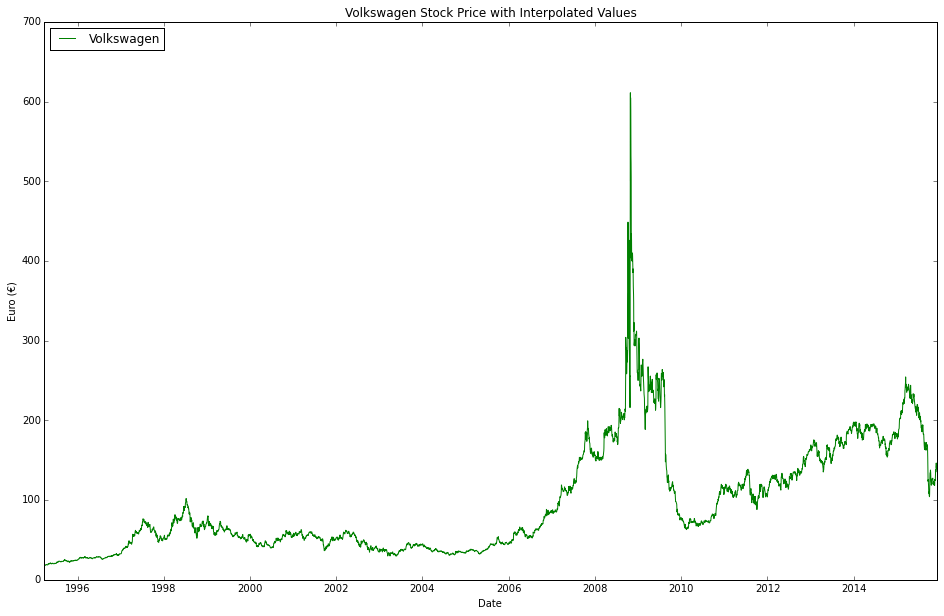

In [11]:
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(all_data.index, all_data[price_type], 'g', label = 'Volkswagen')
plt.title('Volkswagen Stock Price with Interpolated Values')
plt.legend(loc = 2)
plt.ylabel('Euro '+u"(\u20AC)")
plt.xlabel('Date')
plt.show()

# Compare Interpolated Data and Original Data

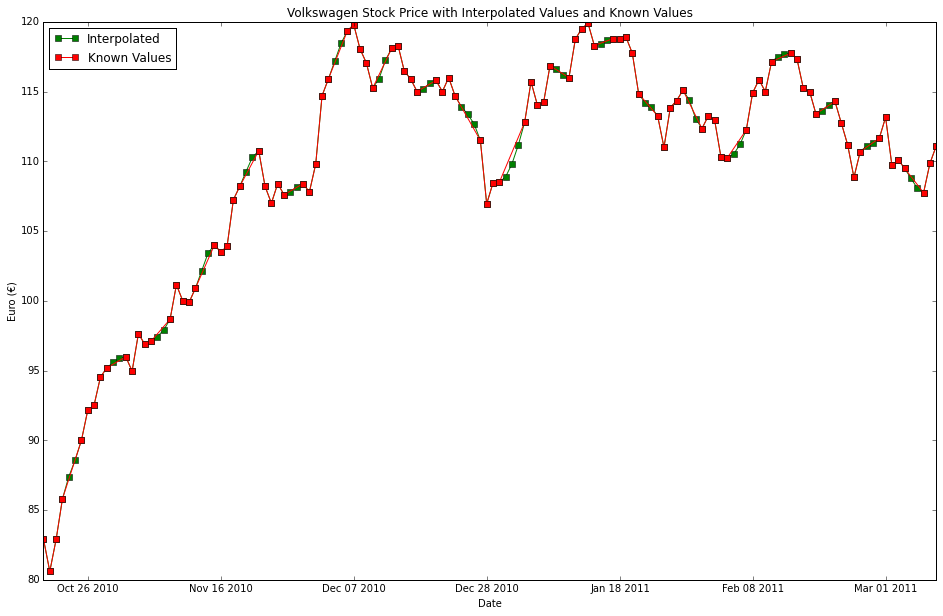

In [12]:
start = 4000
end = 4100
s = np.where(all_dates==known_dates[start])[0][0]
e = np.where(all_dates==known_dates[end])[0][0]
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(all_data.index[s:e], all_data[price_type][s:e], 'gs-', label = 'Interpolated')
plt.plot(known_dates[start:end], known_prices[start:end], 'rs-', label = 'Known Values')
plt.title('Volkswagen Stock Price with Interpolated Values and Known Values')
plt.legend(loc = 2)
plt.ylabel('Euro '+u"(\u20AC)")
plt.xlabel('Date')
plt.show()

# Apply the PELT algorithm

## Define Distribution Parameters

In [13]:
dist = util.Nag_TS_ChangeType
dist_change_point_type_dict = {'Nag_NormalMean': util.Nag_NormalMean, 
                              'Nag_NormalStd': util.Nag_NormalStd, 
                              'Nag_NormalMeanStd': util.Nag_NormalMeanStd, 
                              'Nag_GammaScale': util.Nag_GammaScale, 
                              'Nag_ExponentialLambda': util.Nag_ExponentialLambda, 
                              'Nag_PoissonLambda': util.Nag_PoissonLambda}
dist_change_point_type = 'Nag_NormalMean'
dist = dist_change_point_type_dict[dist_change_point_type]

# Define the penalty term based on the documentation

In [14]:
def penalty_term(dist_change_point_type, time_series_len, penalty_method = 'SIC'):
    if dist_change_point_type == 'Nag_NormalMeanStd':
        p = 2
    else:
        p = 1
    penalty_method_dict = {'SIC': p * np.log(time_series_len), 
                           'BIC': p * np.log(time_series_len), 
                           'AIC': p * 2, 
                           'Hannan-Quinn': 2 * p * np.log(np.log(time_series_len))}
    return penalty_method_dict[penalty_method]

# Calculate the Standard Deviation and the Mean using nag_tsa_mean_range


In [15]:
n = len(all_data[price_type])
m = n
std = np.zeros(n/m, dtype=np.float64)
mean = np.zeros(n/m, dtype=np.float64)
fail = util.noisy_fail()
g13.nag_tsa_mean_range(len(all_data[price_type]), np.array(all_data[price_type].values), m, util.Nag_UseSD, std, mean, fail)
if fail.iflag != 0:
    print fail.message

# Calculate the changepoints

In [16]:
beta = penalty_term(dist_change_point_type, n, 'SIC')
print 'Pentalty Term', beta
minss = 2
param = np.ndarray(1)
if dist_change_point_type == 'Nag_NormalMean':
    param[0] = std[0]
elif dist_change_point_type == 'Nag_NormalMeanStd':
    param[0] = mean[0]
else:
    param[0] = 0
ntau = np.zeros(n, dtype=int)
tau = np.zeros(n, dtype=int)
sparam = np.zeros(2*n+2)
fail = util.noisy_fail()
g13.nag_tsa_cp_pelt(dist, n, np.array(all_data[price_type].values), beta, minss, param, ntau, tau, sparam, fail)
if fail.iflag != 0:
    print fail.message

Pentalty Term 8.93115542978


# Store the mean value between the changepoints


In [17]:
m = ntau[0]
change_points = [0] + tau[0:m-1].tolist()
mean = []
std = []
for i in range(0, m):
    mean.append(sparam[2*(i+1)-2])
    std.append(sparam[2*(i+1)-1])
#This is to plot the final mean bar
change_points.append(len(all_data[price_type].values)-1)
std.append(std[-1])
mean.append(mean[-1])

# Plot the Changepoints and the mean value between them

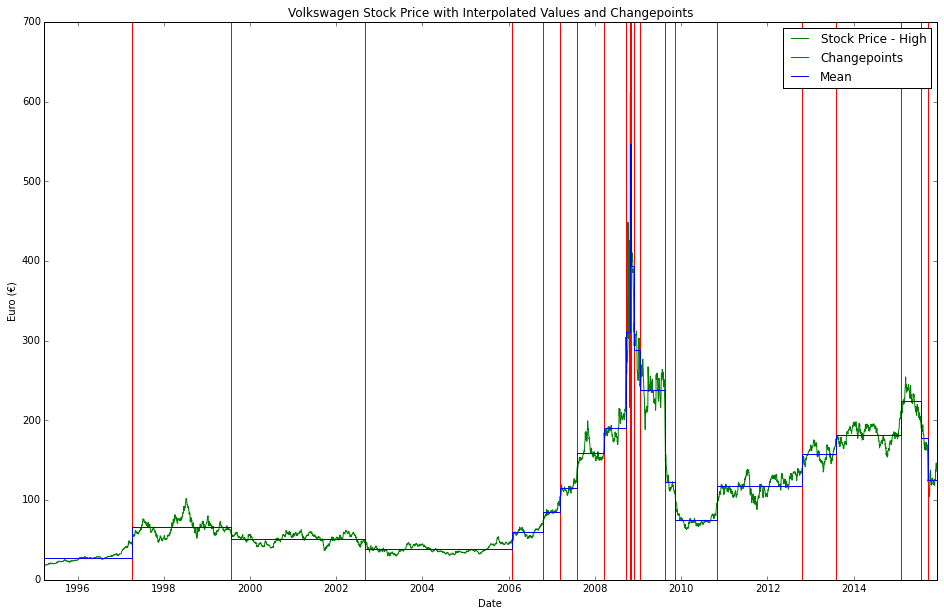

In [18]:
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(all_dates, all_data[price_type].values, 'g', label = 'Stock Price - {}'.format(price_type))
for change_point in change_points:
    plt.axvline(all_dates[change_point], color = 'r')
plt.axvline(all_dates[change_point], color = 'r', label = 'Changepoints')
plt.step(all_dates[change_points], mean, where='post', label = 'Mean')
plt.title('Volkswagen Stock Price with Interpolated Values and Changepoints')
plt.legend()
plt.ylabel('Euro '+u"(\u20AC)")
plt.xlabel('Date')
plt.show()

# A plot showing the changepoint that occurred at the time of the recent emissions scandal¶


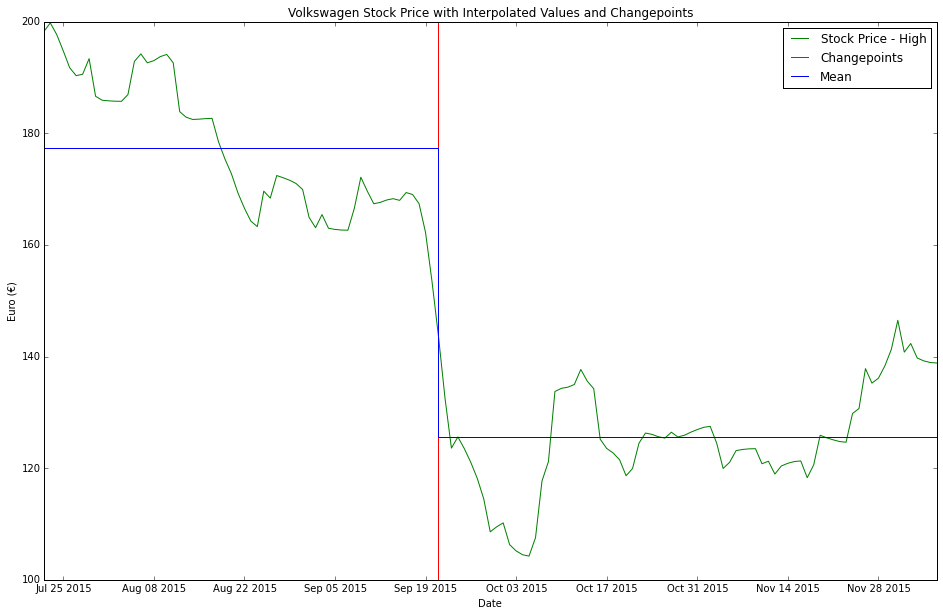

In [19]:
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(all_dates[change_points[-3]:], all_data[price_type].values[change_points[-3]:], 'g', label = 'Stock Price - {}'.format(price_type))
for change_point in change_points[-3:]:
    plt.axvline(all_dates[change_point], color = 'r')
plt.axvline(all_dates[change_point], color = 'r', label = 'Changepoints')
plt.step(all_dates[change_points][-3:], mean[-3:], where='post', label='Mean')
plt.title('Volkswagen Stock Price with Interpolated Values and Changepoints')
plt.legend()
plt.ylabel('Euro '+u"(\u20AC)")
plt.xlabel('Date')
plt.show()